In [1]:
# imports
from transformers import pipeline, BertTokenizer, BertModel, BertConfig
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# https://github.com/jessevig/bertviz
from bertviz import head_view

## Let's start by taking a look at the Bert Tokenizer.

Let's use the `from_pretrained` method to grab the uncased bert-base tokenizer

A list of all available modules can be found on their site: https://huggingface.co/transformers/pretrained_models.html

In [2]:
# load the bert-base uncased tokenizer. Quick check what does "uncased" mean?
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print(f'Length of BERT base vocabulary: {len(tokenizer.vocab)}')

Length of BERT base vocabulary: 30522


In [3]:
text = "A simple sentence!"

tokens = tokenizer.encode(text)
print(tokens)

[101, 1037, 3722, 6251, 999, 102]


In [4]:
# decode will re-construct the sentence with the added [CLS] and [SEP] token
tokenizer.decode(tokens)

'[CLS] a simple sentence! [SEP]'

In [5]:
text = "My friend told me about this class and I love it so far! She was right."

tokens = tokenizer.encode(text)
print(tokens)

[101, 2026, 2767, 2409, 2033, 2055, 2023, 2465, 1998, 1045, 2293, 2009, 2061, 2521, 999, 2016, 2001, 2157, 1012, 102]


In [6]:
# A nicer printout  of token ids and token strings

print(f'Text: {text}. Num tokens: {len(tokens)}')
for t in tokens:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')

Text: My friend told me about this class and I love it so far! She was right.. Num tokens: 20
Token: 101, subword: [CLS]
Token: 2026, subword: my
Token: 2767, subword: friend
Token: 2409, subword: told
Token: 2033, subword: me
Token: 2055, subword: about
Token: 2023, subword: this
Token: 2465, subword: class
Token: 1998, subword: and
Token: 1045, subword: i
Token: 2293, subword: love
Token: 2009, subword: it
Token: 2061, subword: so
Token: 2521, subword: far
Token: 999, subword: !
Token: 2016, subword: she
Token: 2001, subword: was
Token: 2157, subword: right
Token: 1012, subword: .
Token: 102, subword: [SEP]


In [7]:
# Sinan is not in our vocab :'(

'sinan' in tokenizer.vocab

False

In [8]:
text_with_unknown_words = 'Sinan is an amazing teacher.'
tokens_with_unknown_words = tokenizer.encode(text_with_unknown_words)

# We see our sub words in action!
for t in tokens_with_unknown_words:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')

Token: 101, subword: [CLS]
Token: 8254, subword: sin
Token: 2319, subword: ##an
Token: 2003, subword: is
Token: 2019, subword: an
Token: 6429, subword: amazing
Token: 3836, subword: teacher
Token: 1012, subword: .
Token: 102, subword: [SEP]


In [9]:
text_with_unknown_words = 'Sinan is our instructor for this awesomesauce class'
tokens_with_unknown_words = tokenizer.encode(text_with_unknown_words)

for t in tokens_with_unknown_words:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')

Token: 101, subword: [CLS]
Token: 8254, subword: sin
Token: 2319, subword: ##an
Token: 2003, subword: is
Token: 2256, subword: our
Token: 9450, subword: instructor
Token: 2005, subword: for
Token: 2023, subword: this
Token: 12476, subword: awesome
Token: 23823, subword: ##sau
Token: 3401, subword: ##ce
Token: 2465, subword: class
Token: 102, subword: [SEP]


In [10]:
# Let's load a vanilla BERT-base model. 
# Note we have to specify uncased because the vocab size / pre-trained vectors are different
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Get all of the model's parameters as a list of tuples.
named_params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(named_params)))

print('==== Embedding Layer ====\n')
for p in named_params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')
for p in named_params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')
for p in named_params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 199 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias                   (

In [12]:
# The pooler is a separate linear and tanh activated layer that acts on the [CLS] token's representation
# This pooled_output is often used as a representation for the entire sentence.

In [13]:
tokens_with_unknown_words

[101, 8254, 2319, 2003, 2256, 9450, 2005, 2023, 12476, 23823, 3401, 2465, 102]

In [14]:
tokenizer.decode(tokens_with_unknown_words)

'[CLS] sinan is our instructor for this awesomesauce class [SEP]'

In [15]:
len(tokens_with_unknown_words)

13

In [16]:
torch.tensor(tokens_with_unknown_words).unsqueeze(0).shape

torch.Size([1, 13])

In [17]:
# run tokens through  the model

#1 Turn tokens_with_unknown_words into a tensor (will be size (13,))
#2 Unsqueeze a first dimension to simulate batches. Resulting shape is (1, 13)
response = model(torch.tensor(tokens_with_unknown_words).unsqueeze(0))

In [18]:
response

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0135,  0.1796, -0.0491,  ..., -0.0813,  0.4412,  0.2216],
         [ 0.7837, -0.0256,  0.2423,  ..., -0.0865,  0.7038, -0.0435],
         [ 0.6878,  0.1373,  0.2147,  ..., -0.1941,  0.1701, -0.0985],
         ...,
         [ 0.0831, -0.7778, -0.4073,  ..., -0.3047, -0.2619, -0.4428],
         [-0.5723, -0.8018, -0.5488,  ...,  0.0997,  0.0199, -0.4611],
         [ 0.8369,  0.2344,  0.0402,  ...,  0.2753, -0.6154, -0.3641]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-7.5447e-01, -2.6094e-01,  2.8458e-01,  3.0110e-01,  1.3483e-01,
          3.3866e-02,  6.3641e-01,  1.4645e-01,  2.9237e-01, -9.9943e-01,
          1.8216e-01,  2.3032e-02,  9.7297e-01, -2.6279e-01,  8.6701e-01,
         -2.6573e-01,  5.0678e-01, -4.6666e-01,  1.0248e-01, -7.4768e-02,
          4.8551e-01,  9.7481e-01,  6.5860e-01,  2.6781e-01,  3.4194e-01,
          1.3962e-01, -5.0113e-01,  8.9859e-01,  9.1252e-01,  6.863

In [19]:
# Embedding for each token, the first one being the [CLS] token
response.last_hidden_state.shape

torch.Size([1, 13, 768])

In [20]:
# This layer is trained on top of the Embedding of the CLS token

response.pooler_output

tensor([[-7.5447e-01, -2.6094e-01,  2.8458e-01,  3.0110e-01,  1.3483e-01,
          3.3866e-02,  6.3641e-01,  1.4645e-01,  2.9237e-01, -9.9943e-01,
          1.8216e-01,  2.3032e-02,  9.7297e-01, -2.6279e-01,  8.6701e-01,
         -2.6573e-01,  5.0678e-01, -4.6666e-01,  1.0248e-01, -7.4768e-02,
          4.8551e-01,  9.7481e-01,  6.5860e-01,  2.6781e-01,  3.4194e-01,
          1.3962e-01, -5.0113e-01,  8.9859e-01,  9.1252e-01,  6.8631e-01,
         -3.2562e-01,  1.5686e-01, -9.8107e-01, -7.7951e-02,  1.2803e-01,
         -9.6046e-01,  1.3733e-01, -6.4734e-01,  1.4687e-01,  1.7399e-01,
         -7.7996e-01,  1.6257e-01,  9.9683e-01, -7.3986e-01, -2.8199e-01,
         -1.5608e-01, -9.9882e-01,  1.2617e-01, -8.3068e-01, -2.9490e-01,
         -4.0222e-01, -3.7703e-01, -3.2947e-02,  2.0033e-01,  2.9785e-01,
          3.0441e-01, -2.1242e-01, -3.3210e-02, -9.3697e-02, -4.0832e-01,
         -5.1307e-01,  6.1304e-02,  5.7557e-02, -8.1589e-01, -3.4569e-01,
         -4.8677e-01, -2.9740e-02, -1.

In [21]:
model.pooler

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [22]:
# Running the embedding for CLS through the pooler gives the same output as 
(model.pooler(response.last_hidden_state)[0] == response.pooler_output).all()

tensor(True)

# Count the Parameters in BERT

In [23]:
total_params = 0
for p in model.parameters():
    if len(p.shape) == 2:
        total_params += p.shape[0] * p.shape[1]
        
print(f'Total Parameters: {total_params:,}')  # This is where the 110M parameter comes from

Total Parameters: 109,360,128


# A deeper look at token representations

In [24]:
# python is the 6th token (don't forget the [CLS] token!)
python_pet = tokenizer.encode('I love my pet python')

# python is the 6th token (don't forget the [CLS] token!)
python_language = tokenizer.encode('I love programming with python')


# vector representation of the word "python" in "I love my pet python"
python_pet_embedding = model(torch.tensor(python_pet).unsqueeze(0))[0][:,5,:].detach().numpy()

# vector representation of the word "python" in "I love coding in python"
python_language_embedding = model(torch.tensor(python_language).unsqueeze(0))[0][:,5,:].detach().numpy()

# vector representation of the word "snake"
snake_alone_embedding = model(torch.tensor(tokenizer.encode('snake')).unsqueeze(0))[0][:,1,:].detach().numpy()

# vector representation of the word "coding"
coding_alone_embedding = model(torch.tensor(tokenizer.encode('coding')).unsqueeze(0))[0][:,1,:].detach().numpy()


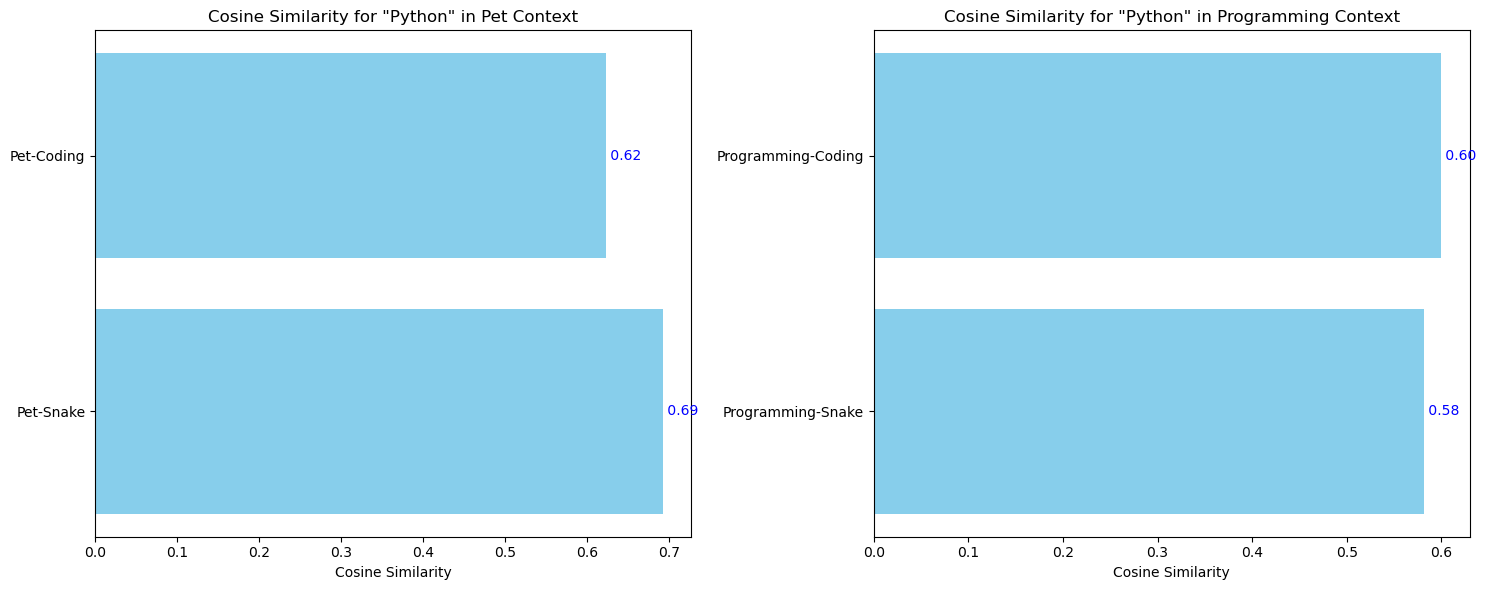

In [25]:

# Calculate cosine similarities
similarity_pet_snake = cosine_similarity(python_pet_embedding, snake_alone_embedding)
similarity_language_snake = cosine_similarity(python_language_embedding, snake_alone_embedding)
similarity_pet_coding = cosine_similarity(python_pet_embedding, coding_alone_embedding)
similarity_language_coding = cosine_similarity(python_language_embedding, coding_alone_embedding)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Chart for Pet Context
labels_pet = ['Pet-Snake', 'Pet-Coding']
values_pet = [similarity_pet_snake[0][0], similarity_pet_coding[0][0]]

axs[0].barh(labels_pet, values_pet, color='skyblue')
axs[0].set_xlabel('Cosine Similarity')
axs[0].set_title('Cosine Similarity for "Python" in Pet Context')
for i, v in enumerate(values_pet):
    axs[0].text(v, i, " {:.2f}".format(v), va='center', color='blue')

# Chart for Language Context
labels_language = ['Programming-Snake', 'Programming-Coding']
values_language = [similarity_language_snake[0][0], similarity_language_coding[0][0]]

axs[1].barh(labels_language, values_language, color='skyblue')
axs[1].set_xlabel('Cosine Similarity')
axs[1].set_title('Cosine Similarity for "Python" in Programming Context')
for i, v in enumerate(values_language):
    axs[1].text(v, i, " {:.2f}".format(v), va='center', color='blue')

# Show the plots
plt.tight_layout()
plt.show()


In [26]:
inputs = torch.tensor(tokens).unsqueeze(0) # unsqueeze changes the shape from (20,) -> (1, 20)

outputs = model(inputs)
print(f'output type: {type(outputs)}, output length: {len(outputs)}')
print(f'first item shape: {outputs[0].shape}')
print(f'second item shape: {outputs[1].shape}')

output type: <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>, output length: 2
first item shape: torch.Size([1, 20, 768])
second item shape: torch.Size([1, 768])


In [27]:
"""
word_embeddings == context-free word embeddings
position_embeddings == encodes word position
token_type_embeddings == 0 or 1. Used to lookup the segment embedding
"""

model.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [28]:
model.embeddings(inputs)

tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [ 0.6533,  0.6978, -0.8019,  ..., -0.5889,  0.0678, -0.2244],
         [-0.8374, -0.3542,  0.4120,  ..., -0.5747, -1.0218,  0.2475],
         ...,
         [-0.3790, -0.0327,  0.2991,  ..., -0.0998, -0.0998, -0.6177],
         [-0.3444,  0.3149,  0.0321,  ...,  0.6340,  0.3512,  0.4887],
         [-0.2748,  0.0045, -0.1727,  ..., -0.1416,  0.0560, -0.1515]]],
       grad_fn=<NativeLayerNormBackward0>)

In [29]:
print(f'number of layers in the encoder stack: {len(model.encoder.layer)}')
print(f'first encoder: {model.encoder.layer[0]}')

number of layers in the encoder stack: 12
first encoder: BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [30]:
model.encoder.layer[0](model.embeddings(inputs))[0].shape  # output of first encoder

torch.Size([1, 20, 768])

In [31]:
attention = model(inputs, output_attentions=True)[2]

In [32]:
# https://nlp.stanford.edu/pubs/clark2019what.pdf
# 2 seems to be attending to the previous token
# 5 seems to be for pronouns

In [33]:
tokens_as_list = tokenizer.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens_as_list)

<IPython.core.display.Javascript object>

In [34]:
# Head 8-10 relating direct objects to their verbs eg told -> me
head_view(attention, tokenizer.convert_ids_to_tokens(inputs[0]), layer=7, heads=[9])

<IPython.core.display.Javascript object>